# 1) Preliminary step

## Import packages and dependencies

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from scipy.sparse.linalg import LinearOperator
import os
import importlib
from pathlib import Path
import scipy.io as sio
from scipy.signal import convolve2d
from scipy.ndimage import convolve
import scipy.stats
import cv2
from PIL import Image
from skimage import io
import plotly.graph_objects as go
import tifffile

DIRECTORY = os.path.abspath('')
os.chdir(DIRECTORY)

from Tools.PSNR import PSNR
from Deblurring.Algortihm.Penalized_MMS_heteroscedastic import P_MMS
from Deblurring.Operators.gradient_operator import generate_G
from Deblurring.Operators.PSF_operator import generate_blur
from Tools.noise_estimation import *

## Load image and select zone of interest 

In [19]:
# Load observed image (blurred + noisy)
path = '/home/julin/Documents/imbilles/crops/1um2/860_495-540_0.049xy_0.5z_2/0.tif'
y_bar = io.imread(path)[:,:,:].transpose(1, 2, 0) 

# Normalize y_bar
y_max = y_bar.max()
y_bar = y_bar / y_max 

print(y_bar.shape)
# Zone of interest
n1_min = 0 
n1_max = n1_min + 128
n2_min = 100
n2_max = n2_min + 128
n3_min = 0
n3_max = 10
y = np.copy(y_bar)

# Sizes of the problem
n1, n2, n3 = y.shape
N = n1 * n2 * n3

(44, 49, 234)


## Show image

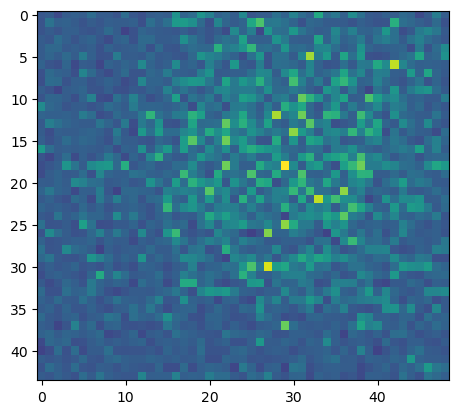

In [20]:
# Check that the slices of y_bar look ok
plt.figure()
plt.imshow(y[:,:,0], vmin=0)
plt.show()

# 2) Estimate noise parameters and prepare rescaling matrix

**Pour Jaj :** dans cette partie on estime le niveau de bruit. On fait l'hypothèse d'un bruit de Poisson qu'on approxime par un bruit Gaussien dit "heteroscedastique" (i.e. de variance qui varie avec l'intensité du pixel). Si tu veux plus d'info tu peux regarder l'article qu'on est en train d'écrire avec Claire (je te l'avais envoyé ?).
En gros 
$$ y = Hx + N(0, a Hx + b)$$
avec $a$ et $b$ deux constantes à determiner. 

Deux possibilités pour toi :
1) Estimer les paramètres $a$ et $b$ en executant le code ci-dessous

2) Fixer $a = 0$ et $b = \sigma^2$

Tant que tu travailles sur des données simulées j'opterais pour 2).

err =  1
err =  0.00027306784407993593
err =  3.103327541890746e-05
err =  1.7543867604185507e-05
err =  1.2259109839560982e-05
err =  9.10562718954661e-06
err =  7.529192660699584e-06
err =  6.4847521125917305e-06
err =  5.433153639043843e-06
err =  4.610645369592509e-06
err =  3.978658008270153e-06
err =  3.3353354468716766e-06
err =  2.8777370549993968e-06
err =  2.6124436619352146e-06
err =  2.3514598386382686e-06
err =  2.1516509368365373e-06
err =  1.9875622283647824e-06
err =  1.8538766783476033e-06
err =  1.7044792738364612e-06
err =  1.504608535022494e-06
err =  1.3842632623259734e-06
err =  1.2940846012450817e-06
err =  1.2016095646236755e-06
err =  1.101598350134375e-06
err =  9.80972344645861e-07
err =  8.505692565759801e-07
err =  7.459948490752923e-07
err =  6.515733876527379e-07
err =  6.049934609548549e-07
err =  5.801631359419275e-07
err =  5.22297467747462e-07
err =  4.892932295968283e-07
err =  4.521889765199134e-07
err =  3.948230224526492e-07
err =  3.2872699570201

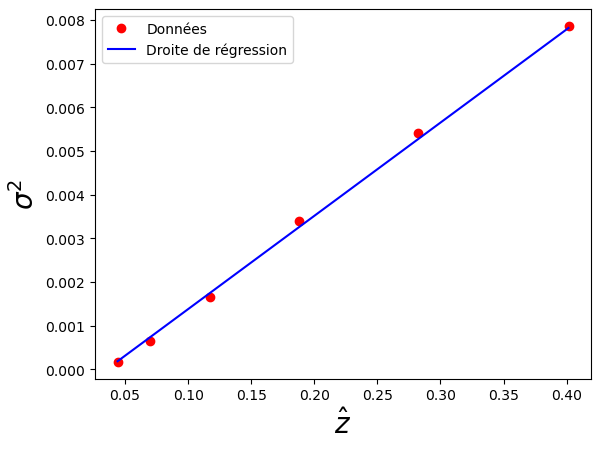

In [21]:
def estimate_params(y, params=None, plot_regression=False):
    if params is not None:
        n3_min, n3_max, z_init, z_inter = params
        im = y[:, :, n3_min : n3_max]
    else :
        im = y

    im_conv = blur(im, im.shape)

    xq, list_S, d, r = LM_quantifier(im_conv[:, :, :], 8)
    
    list_var = []
    list_I = []
    for S in list_S:
        n = np.sum(S)
        I = np.sum(S*im)/n
        list_I.append(I)
        list_var.append(1/(n-1) * np.sum((S*(im - I))**2))

    a, b = scipy.stats.linregress(list_I[:], list_var[:])[:2]
    
    if plot_regression == True:
        plt.figure()
        plt.plot(list_I[:-1], list_var[:-1], 'ro', label='Données')
        plt.plot(list_I[:-1], a * np.array(list_I[:-1]) + b, 'b-', label="Droite de régression")
        plt.xlabel(r'$\hat{z}$', fontsize=20)
        plt.ylabel(r'$\sigma^2$', fontsize=20)
        plt.legend()
        plt.show()
    
    return a, b

a, b  = estimate_params(y, plot_regression=True)

In [23]:
print("Estimated parameters:")
print("a = ", a)
print("b = ", b)

Estimated parameters:
a =  0.021371423213048184
b =  -0.0007595657419299925


# 3) Restoration

## Load PSF kernel

In [10]:
h = np.real(sio.loadmat('Data/muscle_gdf8/profondeur/kernel_psf.mat')['h']) # size 21 x 21 x 21

# define LinearOperator x --> h * x
H = generate_blur(h, (n1, n2, n3))

## Set parameters of the restoration algorithm

In [18]:
x_0 = np.copy(y)           # initialization 
delta = 0.1                # parameter in the TV regularization 
eta = 1.0                  # parameter on the constraint. Should always be close to 1 !
x_min = 0                  # minimum pixel value in the restored image
x_max = 1                  # maximum pixel value in the restored image
res = (0.049,0.049,0.1)    # resolution
max_iter = 1000            # maximum number of iteration of the algorithm
tolerance = 2*1e-04*N    # for stopping criterion
noise_params = (a, b)

## Set scaling matrix D

In [20]:
y_conv =  blur(y, y.shape, KERNEL_SIZE=11, sigma=5)
D_scale = np.ones(N) / np.sqrt(abs(a * y_conv.reshape(N) + b))

## Run algorithm 

**Pour Jaj**:
L'algo est constitué de deux algos embriqués l'un dans l'autre. Quand on execute l'algo, il y a les itérations affichées. 

"iter" (en minuscule) --> algo intérieur

"ITER" (en majuscule) --> algo exterieur

C'est pas une idée incroyable je sais, il faudra que je change cela un jour. Mon critère d'arret porte sur le truc qui s'appelle "criterion" dans l'affichage. Ici il correspond à la différence entre deux itérées de l'algo exterieur. Mais entre nous ce n'est pas idéal. 

Il y a beaucoup de quantités affichées : 
- Psi : fonction de régularisation
- R1 : fonction de pénalisation pour la contrainte 1 (qui est que les pixels doivent être entre 0 et 1)
- R2 : fonction de pénalisation pour la contrainte 2 (qui porte sur le terme d'attache aux données, et qui est controlée par le paramètre eta)


In [21]:
x_opt =  P_MMS(np.copy(y), H, delta, eta, x_0, np.copy(y), x_min, x_max, res, noise_params, D_scale, max_iter, tolerance)

iter = 0, error = 14089.771314355352, PSNR = 24.26, Psi=228542.65463956085, R1 = 0.0, R2 = 64.05765887048906
iter = 20, error = 1513.5135522818152, PSNR = 20.56, Psi=62170.93350277994, R1 = 0.0072613179416168815, R2 = 7099.967176543417
iter = 40, error = 748.5354855708048, PSNR = 19.02, Psi=56289.577499432104, R1 = 4.2523732384811294e-10, R2 = 31888.036283453028
iter = 60, error = 189.92322924466473, PSNR = 18.49, Psi=54328.342564510436, R1 = 0.0, R2 = 54234.94706443603
iter = 80, error = 57.20208563230808, PSNR = 18.44, Psi=54173.93882732366, R1 = 0.0, R2 = 56577.9338875354
iter = 100, error = 17.134354519567225, PSNR = 18.42, Psi=54141.404638469176, R1 = 0.0, R2 = 57121.030812260135
iter = 120, error = 4.965664145924934, PSNR = 18.42, Psi=54141.011704871875, R1 = 0.0, R2 = 57148.10110845119
ITER = 1, GAMMA = [0.08944272 0.04698476], EPS = 2.128350, criterion = 57143.135890659476
--------------------

iter = 0, error = 616.2097078361039, PSNR = 19.05, Psi=54141.295777331696, R1 = 0.0,

ITER = 15, GAMMA = [5.19615242 8.06362614], EPS = 0.059343, criterion = 348.65919924334014
--------------------

iter = 0, error = 9.41147143107811, PSNR = 22.02, Psi=71063.93114755843, R1 = 0.0, R2 = 312.9586171660884
iter = 20, error = 1.294531640082389, PSNR = 22.02, Psi=71098.13861713349, R1 = 0.0, R2 = 309.5129937748568
iter = 40, error = 0.23934204507485185, PSNR = 22.02, Psi=71100.73745448794, R1 = 0.0, R2 = 309.1774956074764
iter = 60, error = 0.05244714549017526, PSNR = 22.02, Psi=71100.43344923125, R1 = 0.0, R2 = 309.189452851348
ITER = 16, GAMMA = [5.72433402 9.11559368], EPS = 0.057551, criterion = 309.19442711302315
--------------------

iter = 0, error = 8.418058500081811, PSNR = 22.04, Psi=71417.09580514673, R1 = 0.0, R2 = 279.44076692065084
iter = 20, error = 1.2573156382863393, PSNR = 22.04, Psi=71446.63181468671, R1 = 0.0, R2 = 276.804695468062
iter = 40, error = 0.2356353254337955, PSNR = 22.04, Psi=71449.46732497154, R1 = 0.0, R2 = 276.4805132472406
iter = 60, error

ITER = 30, GAMMA = [14.69693846 30.09451687], EPS = 0.042695, criterion = 103.90237426282745
--------------------

iter = 0, error = 2.8344416819659815, PSNR = 22.13, Psi=74800.26769271425, R1 = 0.0, R2 = 98.94624830454717
iter = 20, error = 0.991207763539034, PSNR = 22.13, Psi=74806.77704294094, R1 = 0.0, R2 = 98.76357827396228
iter = 40, error = 0.25271427198469004, PSNR = 22.13, Psi=74809.17948733528, R1 = 0.0, R2 = 98.69050099208827
iter = 60, error = 0.08732411850144818, PSNR = 22.13, Psi=74809.5347811149, R1 = 0.0, R2 = 98.6775576559794
ITER = 31, GAMMA = [15.4378755  32.02906126], EPS = 0.042035, criterion = 98.67945020350453
--------------------

iter = 0, error = 2.676357101830204, PSNR = 22.14, Psi=74975.04383035556, R1 = 0.0, R2 = 94.16775895186998
iter = 20, error = 0.9397570850508581, PSNR = 22.14, Psi=74981.03744338454, R1 = 0.0, R2 = 94.00957301451648
iter = 40, error = 0.2520276856169346, PSNR = 22.14, Psi=74983.37835367482, R1 = 0.0, R2 = 93.9431282531217
iter = 60, er

ITER = 45, GAMMA = [27.        65.0220665], EPS = 0.035216, criterion = 57.861663425059575
--------------------

iter = 0, error = 1.3954911490998132, PSNR = 22.12, Psi=76965.8865001539, R1 = 0.0, R2 = 56.31175554933367
iter = 20, error = 0.6674953517749295, PSNR = 22.12, Psi=76968.25827538704, R1 = 0.0, R2 = 56.28088963525011
iter = 40, error = 0.23454567162947768, PSNR = 22.12, Psi=76969.6917157545, R1 = 0.0, R2 = 56.26174909975084
iter = 60, error = 0.07882591748829766, PSNR = 22.12, Psi=76970.04220441451, R1 = 0.0, R2 = 56.256343035536254
ITER = 46, GAMMA = [27.90498163 67.79487619], EPS = 0.034850, criterion = 56.2566469197202
--------------------

iter = 0, error = 1.3420549583197807, PSNR = 22.12, Psi=77084.1662449508, R1 = 0.0, R2 = 54.801233771011965
iter = 20, error = 0.6442570774684531, PSNR = 22.12, Psi=77086.38774085035, R1 = 0.0, R2 = 54.773638533848356
iter = 40, error = 0.2331672384874651, PSNR = 22.12, Psi=77087.78762761691, R1 = 0.0, R2 = 54.7556254482242
iter = 60, e

ITER = 60, GAMMA = [ 41.56921938 112.31670843], EPS = 0.030718, criterion = 41.37171934758954
--------------------

iter = 0, error = 0.8558645322262403, PSNR = 22.09, Psi=78535.29130128399, R1 = 0.0, R2 = 40.68810760081055
iter = 20, error = 0.4543991907489993, PSNR = 22.09, Psi=78536.64397986812, R1 = 0.0, R2 = 40.67834008198622
iter = 40, error = 0.1504713029675183, PSNR = 22.09, Psi=78537.5509959686, R1 = 0.0, R2 = 40.67143347245403
iter = 60, error = 0.04959212211771668, PSNR = 22.09, Psi=78537.79378259032, R1 = 0.0, R2 = 40.66940043177701
ITER = 61, GAMMA = [ 42.61276804 115.90006467], EPS = 0.030477, criterion = 40.6701910026168
--------------------

iter = 0, error = 0.831837860813763, PSNR = 22.08, Psi=78627.54648226916, R1 = 0.0, R2 = 40.017546250437036
iter = 20, error = 0.433023706486585, PSNR = 22.08, Psi=78628.80711800698, R1 = 0.0, R2 = 40.00875571002812
iter = 40, error = 0.15608212312819972, PSNR = 22.08, Psi=78629.72465724465, R1 = 0.0, R2 = 40.00205100602234
iter = 6

ITER = 75, GAMMA = [ 58.09475019 171.6221713 ], EPS = 0.027628, criterion = 33.47083032821056
--------------------

iter = 0, error = 0.6121357209444002, PSNR = 22.04, Psi=79817.48568513062, R1 = 0.0, R2 = 33.10036154172827
iter = 20, error = 0.3039404496059695, PSNR = 22.04, Psi=79818.52737527652, R1 = 0.0, R2 = 33.095802973278644
iter = 40, error = 0.10090366518422635, PSNR = 22.04, Psi=79819.1694061049, R1 = 0.0, R2 = 33.09262421359072
iter = 60, error = 0.029697840803287696, PSNR = 22.04, Psi=79819.35975486833, R1 = 0.0, R2 = 33.0916356159961
ITER = 76, GAMMA = [ 59.26050962 175.99600799], EPS = 0.027455, criterion = 33.092570934444126
--------------------

iter = 0, error = 0.5997181877970845, PSNR = 22.04, Psi=79896.92969048268, R1 = 0.0, R2 = 32.73484696599121
iter = 20, error = 0.3019986356704046, PSNR = 22.04, Psi=79897.92993686195, R1 = 0.0, R2 = 32.730637543149825
iter = 40, error = 0.10427890205131234, PSNR = 22.04, Psi=79898.56114145789, R1 = 0.0, R2 = 32.72755251008212
it

## Display restored image and save to eps file 

In [22]:
x_opt_deblurred = x_opt * y_max

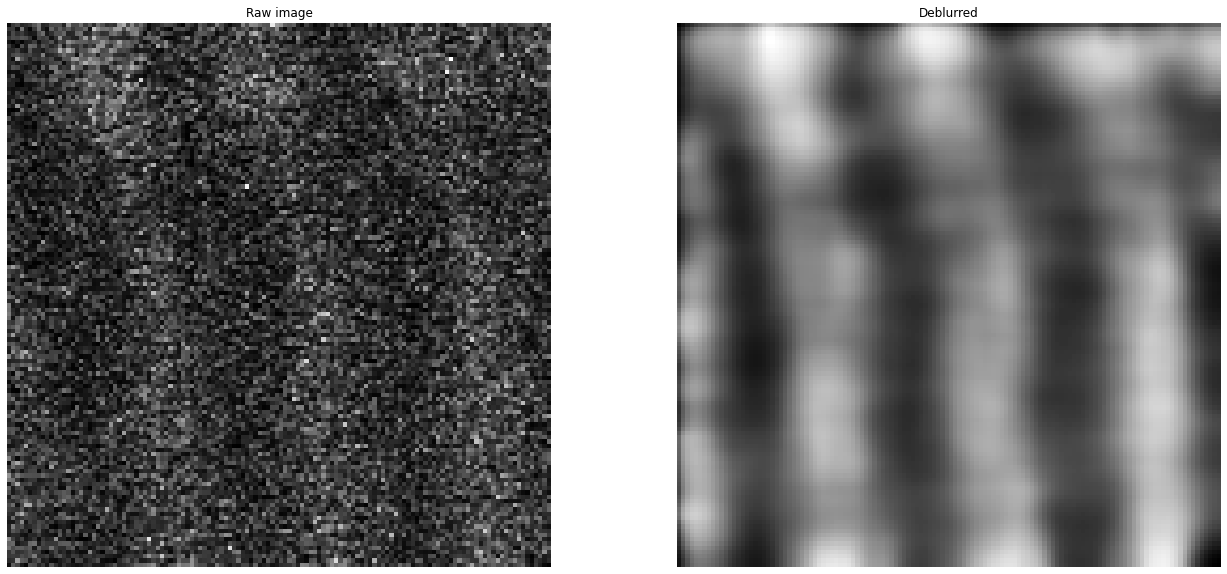

In [24]:
i = 0
plt.figure(figsize=(22,10))

plt.subplot(1, 2, 1)
plt.imshow(y[:,:,0], cmap="gray")
plt.axis('off')
plt.title(r'Raw image')

plt.subplot(1, 2, 2)
plt.imshow(x_opt_deblurred[:,:,0], cmap="gray")
plt.axis('off')
plt.title(r'Deblurred')
plt.show()

plt.show()


In [324]:
im_restored =  x_opt_deblurred[:,:,:]

tifffile.imsave('Data/muscle_gdf8/Results/im_restored_delta{}_eta{}.tif'.format(delta, eta),test.transpose(2, 0, 1))
tifffile.imsave('Data/muscle_gdf8/Results/im_brute.tif',y.transpose(2, 0, 1))